### Environment Setup

In [1]:
#pip install pandas numpy nltk scikit-learn matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


### Load the Dataset

In [3]:
# Load the dataset
file_path = "training.csv"  # Adjust the path as needed
columns = ["target", "ids", "date", "flag", "user", "text"]
data = pd.read_csv(file_path, encoding="latin-1", names=columns)

# Quick overview
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Check for Missing Values

In [4]:
print(data.isnull().sum())

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64


### Analyze Sentiment Distribution

In [5]:
# Check the class distribution in the 'target' column
print(data['target'].value_counts())


0    800000
4    800000
Name: target, dtype: int64


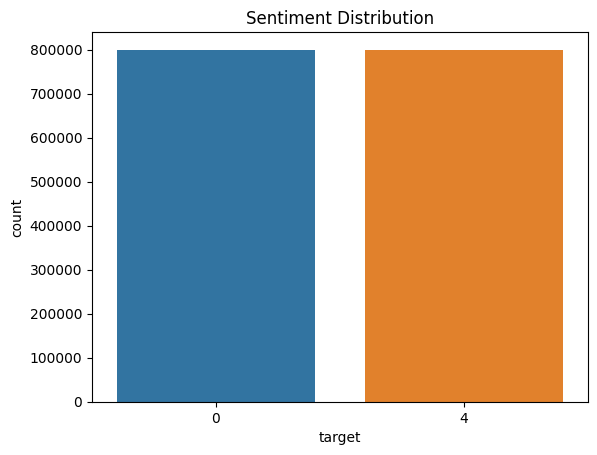

In [6]:
sns.countplot(data=data, x="target")
plt.title("Sentiment Distribution")
plt.show()


#### Balancing and Reducing Dataset to 50,000 Rows

In [7]:
# Reduce dataset to 50000 rows, ensuring balanced classes
df = data.groupby('target').apply(lambda x: x.sample(n=50000 // data['target'].nunique(), random_state=42)).reset_index(drop=True)

# Verify the new distribution
print(df['target'].value_counts())
print(df.shape)

0    25000
4    25000
Name: target, dtype: int64
(50000, 6)


### Preprocess the Data

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def preprocess_tweet(tweet):
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    tweet = tweet.lower()
    words = word_tokenize(tweet)
    return ' '.join([word for word in words if word not in stop_words])

df['clean_text'] = df['text'].apply(preprocess_tweet)
print(df[['text', 'clean_text']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ashok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ashok\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                                text  \
0  @xnausikaax oh no! where did u order from? tha...   
1  A great hard training weekend is over.  a coup...   
2  Right, off to work  Only 5 hours to go until I...   
3                    I am craving for japanese food    
4  Jean Michel Jarre concert tomorrow  gotta work...   

                                          clean_text  
0                          oh u order thats horrible  
1  great hard training weekend couple days rest l...  
2                     right work hours go im free xd  
3                              craving japanese food  
4  jean michel jarre concert tomorrow got ta work...  


#### Verify Preprocessing

In [22]:
# Example to check if URLs are removed
print(df[df['clean_text'].str.contains('http')])

# Randomly sample a row
print(df.sample(1)[['text', 'clean_text']])

# Combine all cleaned text and find unique words
all_words = ' '.join(df['clean_text']).split()
unique_words = set(all_words)
print("\nSample unique words:", list(unique_words)[:20])

       target         ids                date      flag       user  \
10524       0  2193395552 2009-06-16 08:24:03  NO_QUERY    CShiels   
43191       4  1972580836 2009-05-30 09:29:41  NO_QUERY   Creat1ve   
49705       4  1957498942 2009-05-29 00:41:32  NO_QUERY  SuButcher   

                                                    text  \
10524  Wtf is http streaming??? I still want flash 10...   
43191  8 away from 400!   Http://YouTube.com/iphonean...   
49705  Hi to new followers, if you would like to know...   

                                              clean_text  hour  
10524  wtf http streaming still want flash iphone sun...     8  
43191  away httpyoutubecomiphoneandipodhelp please he...     9  
49705       hi new followers would like know httpowlysww     0  
                                                    text  \
16256  @YEBies I gotta go to work soon though (for fr...   

                                      clean_text  
16256  got ta go work soon though free wont ti

### Feature Engineering


#### Convert Text to TF-IDF Features

In [11]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['target']


#### Split the Dataset


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (40000, 5000)
Testing data shape: (10000, 5000)


### Model Training and Evaluation


#### Train a Logistic Regression Model

In [13]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

#### Make Predictions & Evaluate Performance

In [14]:
#Make Predictions
predictions = model.predict(X_test)

#Evaluate Performance
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.77      0.74      0.76      5022
           4       0.75      0.77      0.76      4978

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



### Save Data to a Local Database

#### Set Up SQLite Database

In [15]:
import sqlite3

conn = sqlite3.connect('sentiment_analysis.db')
df[['target', 'clean_text']].to_sql('tweets', conn, if_exists='replace', index=False)
print("Data saved to SQLite database.")


Data saved to SQLite database.


### Verify Data in SQLite

In [16]:
query = "SELECT * FROM tweets LIMIT 5;"
print(pd.read_sql(query, conn))


   target                                         clean_text
0       0                          oh u order thats horrible
1       0  great hard training weekend couple days rest l...
2       0                     right work hours go im free xd
3       0                              craving japanese food
4       0  jean michel jarre concert tomorrow got ta work...


### Visualize Results

#### Sentiment Distribution

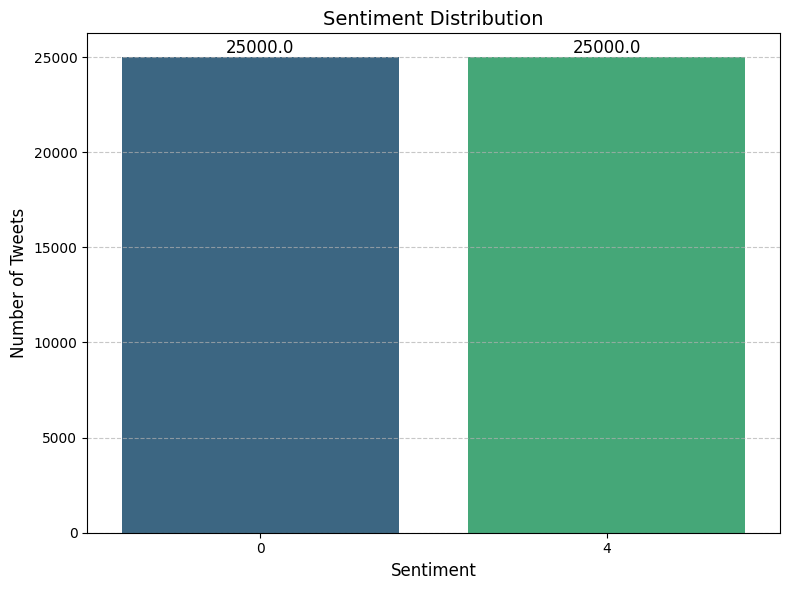

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is already defined and contains the 'target' column
plt.figure(figsize=(8, 6))

# Create the countplot with a custom color palette
sns.countplot(data=df, x="target", palette="viridis")

# Adding annotations on top of each bar
for p in plt.gca().patches:
    plt.annotate(f'{p.get_height()}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', fontsize=12, color='black')

# Title and labels
plt.title("Sentiment Distribution", fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)

# Display gridlines
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Ensure everything fits within the figure area
plt.tight_layout()

# Show the plot
plt.show()


#### Model Metrics Visualization

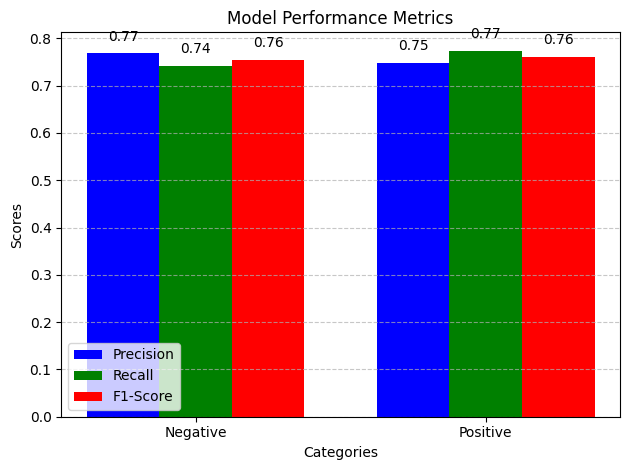

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Assuming y_test and predictions are already defined
metrics = precision_recall_fscore_support(y_test, predictions, average=None)
categories = ['Negative', 'Positive']

# Create the plot
bar_width = 0.25
index = np.arange(len(categories))

# Plotting precision, recall, and F1-score
plt.bar(index - bar_width, metrics[0], bar_width, color='b', label='Precision')
plt.bar(index, metrics[1], bar_width, color='g', label='Recall')
plt.bar(index + bar_width, metrics[2], bar_width, color='r', label='F1-Score')

# Add the text labels on top of the bars
for i in range(len(categories)):
    plt.text(index[i] - bar_width, metrics[0][i] + 0.02, f'{metrics[0][i]:.2f}', ha='center', va='bottom')
    plt.text(index[i], metrics[1][i] + 0.02, f'{metrics[1][i]:.2f}', ha='center', va='bottom')
    plt.text(index[i] + bar_width, metrics[2][i] + 0.02, f'{metrics[2][i]:.2f}', ha='center', va='bottom')

# Set the labels, title, and legend
plt.xlabel('Categories')
plt.ylabel('Scores')
plt.title("Model Performance Metrics")
plt.xticks(index, categories)
plt.legend()

# Show gridlines for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Ensure everything fits nicely within the figure area
plt.tight_layout()

# Display the chart
plt.show()


**Interpretation:**

For the Negative category, precision is slightly higher than recall, while F1-Score is balanced between precision and recall.

For the Positive category, recall is slightly higher than precision, with F1-Score remaining balanced.

#### Word Clouds

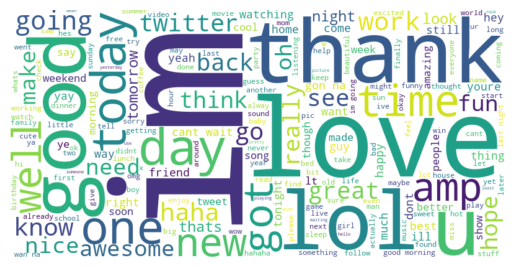

In [19]:
from wordcloud import WordCloud

def plot_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

positive_text = " ".join(df[df['target'] == 4]['clean_text'])
plot_wordcloud(positive_text)


#### Sentiment vs. Date

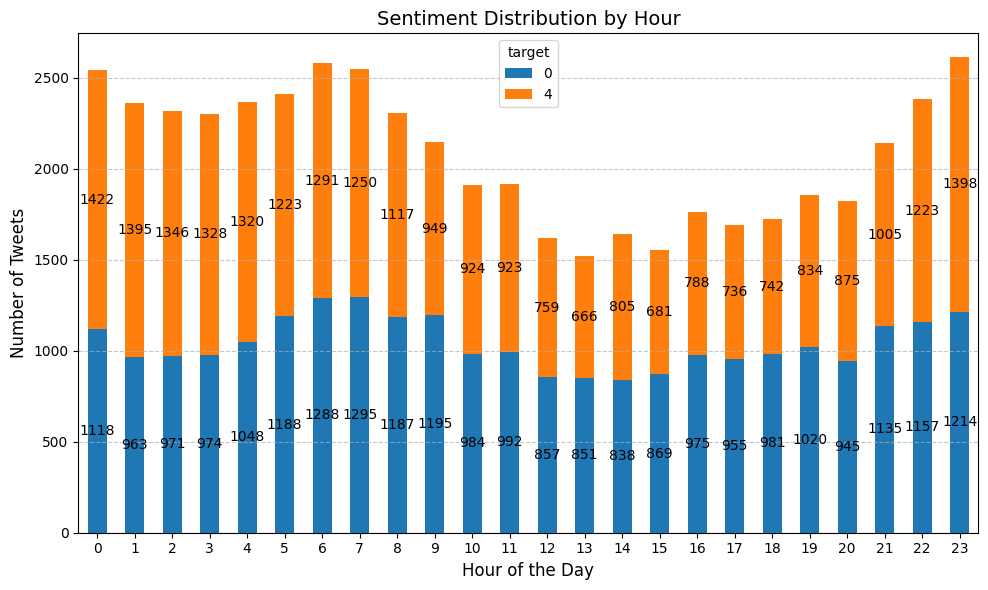

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your DataFrame
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df_grouped = df.groupby(['hour', 'target']).size().unstack().fillna(0)

# Plotting the stacked bar plot
ax = df_grouped.plot(kind='bar', stacked=True, figsize=(10, 6))

# Adding the labels on top of the bars
for i, p in enumerate(ax.patches):
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2  # Position label at the middle of each bar segment

    # Check if height is greater than 0 to avoid placing labels for empty segments
    if height > 0:
        ax.annotate(f'{int(height)}', (x, y),
                    ha='center', va='center', fontsize=10, color='black')

# Title and labels
plt.title("Sentiment Distribution by Hour", fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)

# Customizing the x-ticks and y-axis grid
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Ensure proper layout for all elements
plt.tight_layout()

# Display the plot
plt.show()
